### Ruben Abbou
## A Third Order Method for ODE’s

Solver that approximates the solution of initial value problems for systems of ordinary differential systems using a third order predictor corrector technique.

Prediction at $t_{mid} = \frac{t_{now} + t_{new}}{2}$:

$$ \vec{y}_{mid} = \vec{y}_{now} + \frac{dt}{2}f(t_{now}, \vec{y}_{now})$$

This is used to make an approximation at $t_{new}$:

$$\vec{y}_{dt} = \vec{y}_{now} + dtf(t_{mid}, \vec{y}_{mid})$$

We expect that the error in the change over the interval $[t_{now},t_{new}]$ is smaller by a factor of four for the half-step approximation when compared to the single step approximation. So we will use

$$\vec{y}_{new} = \frac{4}{3}\vec{y}_{dt/2} - \frac{1}{3}\vec{y}_{dt}$$

In [1]:
from numpy.linalg import norm
from numpy import pi, zeros, array, log10
import matplotlib.pyplot as plt

In [2]:
class simTime:
    '''
    Object which encapsulates the information associated with time stepping in an object.
    Inputs:
        - time: start time
        - tol: tolerance
        - endTime: finish time
    '''
    def __init__(self, time, tol, dtmin, dtmax, endTime, agrow=1.25, ashrink=0.8):
        self.time = time
        self.tol = tol
        self.agrow = agrow
        self.ashrink = ashrink
        self.dtmin = dtmin
        self.dtmax = dtmax
        self.dt = dtmin
        self.endTime = endTime
        self.stepsSinceRejection = 0
        self.stepsRejected = 0
        self.stepsAccepted = 0
        
    def __str__(self):
        out = "TIME OBJECT REPORT:"
        out += '\n - Tolerance used: {}'.format(self.tol)
        out += '\n - Number of steps accepted: {}'.format(self.stepsAccepted)
        out += '\n - Number of steps rejected: {}'.format(self.stepsRejected)
        return out

In [3]:
def pred_corrector(f, Y_now, dt, t_now):
    '''
    Predictor corrector method
    Inputs:
        - Y_now: current state of Y
        - t_now: current time
        - f: function
        - dt: step size
    Outputs: Y_new: new Y
    '''
    W = Y_now + dt/2 * f(t_now, Y_now)
    return Y_now + dt * f(t_now + dt/2, W)

def step(f, Y_now, dt, t_now):
    '''
    Do a step of length dt
    Inputs:
        - Y_now: current state of Y
        - t_now: current time
        - f: function
        - dt: step size
    Outputs:
        - Y_new: approximation of Y with time step
        - ddY: difference between the predictions of Y_new
    '''
    Y_dt = pred_corrector(f, Y_now, dt, t_now)
    
    Y_mid = pred_corrector(f, Y_now, dt/2, t_now)
    Y_dt2 = pred_corrector(f, Y_mid, dt/2, t_now + dt/2)

    Y_new = (4*Y_dt2 - Y_dt) / 3
    ddY = Y_dt2 - Y_dt
    return Y_new, ddY

In [4]:
def advance(time_obj, Y_now, f):
    '''
    Advances time until end of the interval
    Inputs:
        - time_obj: simTime object containing stepping values
        - Y_now: initial value of Y
        - f: function
    Outputs:
        - Y_now: final Y prediction
    '''
    # initialize output vector
    out = [[time_obj.time, time_obj.dt, log10(time_obj.dt), 0, Y_now]]
    while True:
        # do a step
        Y_new, ddY = step(f, Y_now, time_obj.dt, time_obj.time)
        e_i = norm(ddY)
        if e_i > time_obj.tol and time_obj.dt > time_obj.dtmin:
            # bad step
            time_obj.dt /= 2
            time_obj.stepsRejected += 1
            time_obj.stepsSinceRejection = 0
        else:
            # good step
            time_obj.time += time_obj.dt
            Y_now = Y_new
            out.append([time_obj.time, time_obj.dt, log10(time_obj.dt), e_i, Y_now])
            time_obj.stepsSinceRejection += 1
            time_obj.stepsAccepted += 1
            if time_obj.time >= time_obj.endTime:
                break
                
            # time step adjustments, nominate new dt
            if time_obj.stepsSinceRejection > 10:
                if e_i <  time_obj.tol / 4:
                    time_obj.dt *= time_obj.agrow
                if e_i > 0.75 * time_obj.tol:
                    time_obj.dt *= time_obj.ashrink
            if time_obj.dt < time_obj.dtmin:
                time_obj.dt = time_obj.dtmin
            if time_obj.dt > time_obj.dtmax:
                time_obj.dt = time_obj.dtmax
            while time_obj.time + time_obj.dt > time_obj.endTime:
                time_obj.dt *= time_obj.ashrink
            if time_obj.time + 2*time_obj.dt > time_obj.endTime and \
                time_obj.time + time_obj.dt < time_obj.endTime:
                time_obj.dt = (time_obj.endTime - time_obj.time) / 2

    return array(out), time_obj

### Case $f(t, \mathbf{y}) = t^m$ for $m=0,1,2,3$

In [5]:
f = lambda t, Y: array([t**m for m in range(4)])
time_obj = simTime(time=0, tol=.01, endTime=2, dtmin=.1, dtmax=1)
result, time_obj = advance(time_obj, zeros(4), f)
print('Approximation of f at x=2:', result[-1][4])
print(time_obj)
print()

time_obj = simTime(time=0, tol=.001, endTime=2, dtmin=.1, dtmax=1)
result, time_obj = advance(time_obj, zeros(4), f)
print('Approximation of f at x=2:', result[-1][4])
print(time_obj)

Approximation of f at x=2: [2.         2.         2.66666667 4.        ]
TIME OBJECT REPORT:
 - Tolerance used: 0.01
 - Number of steps accepted: 16
 - Number of steps rejected: 0

Approximation of f at x=2: [2.         2.         2.66666667 4.        ]
TIME OBJECT REPORT:
 - Tolerance used: 0.001
 - Number of steps accepted: 63
 - Number of steps rejected: 0


### Motion of a Comet about the sun

The equation for the motion of a comet about the sun is $r'' = -\frac{r}{|r|^3}$. We have $r(0) = (1,0), r'(0)=(0,0.3)$. Let's transform this second order system into a first order system:

<!-- $$w(t) = \begin{bmatrix} r \\ r' \end{bmatrix} \Rightarrow w'(t) = \begin{bmatrix} r' \\ r'' \end{bmatrix} = \begin{bmatrix} w_1(t) \\ -\frac{w_0(t)}{\left|w_0(t)\right|^3} \end{bmatrix} $$ -->

$$w(t) = (r, r') \Rightarrow w'(t) = (r', r'') = \left(w_1(t), -\frac{w_0(t)}{\left|w_0(t)\right|^3}\right)$$

so

<!-- $$w(0) =  \begin{bmatrix} 1 \\ 0 \\ 0 \\ 0.3\end{bmatrix} \quad \text{and} \quad w'(0) =  \begin{bmatrix} 0 \\ 0.3 \\  -\frac{1}{1^2+0^2} \\  -\frac{0}{1^2+0^2}\end{bmatrix}  =  \begin{bmatrix} 0 \\ 0.3 \\ -1 \\ 0 \end{bmatrix} $$ -->

$$w(0) =  [1,0,0,0.3] \quad \text{and}\quad w'(0) =  \left[0,0.3, -\frac{1}{1^2+0^2}, -\frac{0}{1^2+0^2}\right]  =  [0,0.3,-1,0] $$

A period lasts $\frac{2\pi}{\left(2-0.3^2\right)^{1.5}}$. We will study the morion of a comet during 3 periods.

In [6]:
def w(t, z):
    w = zeros(4)
    w[:2] = z[2:] # x', y'
    w[2:] = -z[:2]/norm(z[:2])**3 # x'', y''
    return w

TIME OBJECT REPORT:
 - Tolerance used: 0.01
 - Number of steps accepted: 219
 - Number of steps rejected: 19


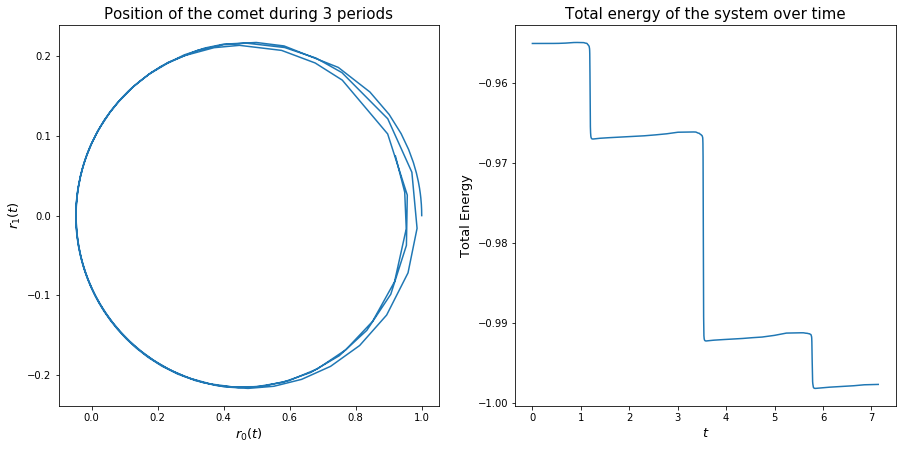

TIME OBJECT REPORT:
 - Tolerance used: 0.001
 - Number of steps accepted: 385
 - Number of steps rejected: 18


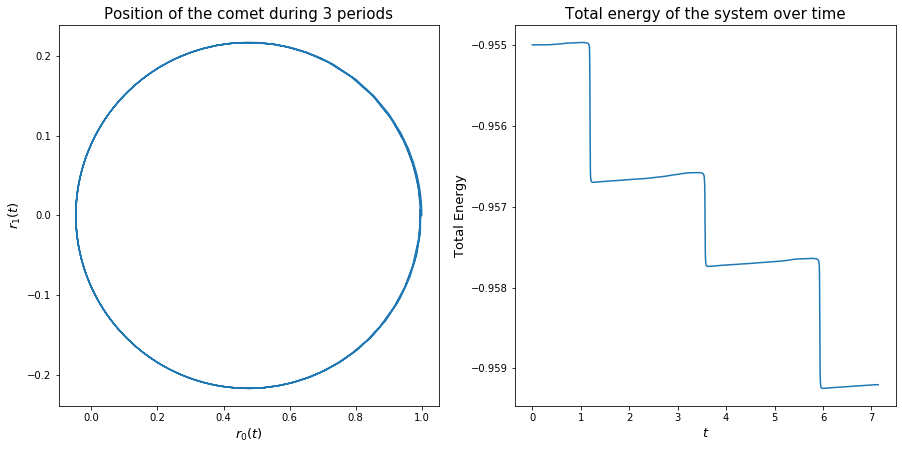

TIME OBJECT REPORT:
 - Tolerance used: 0.0001
 - Number of steps accepted: 686
 - Number of steps rejected: 0


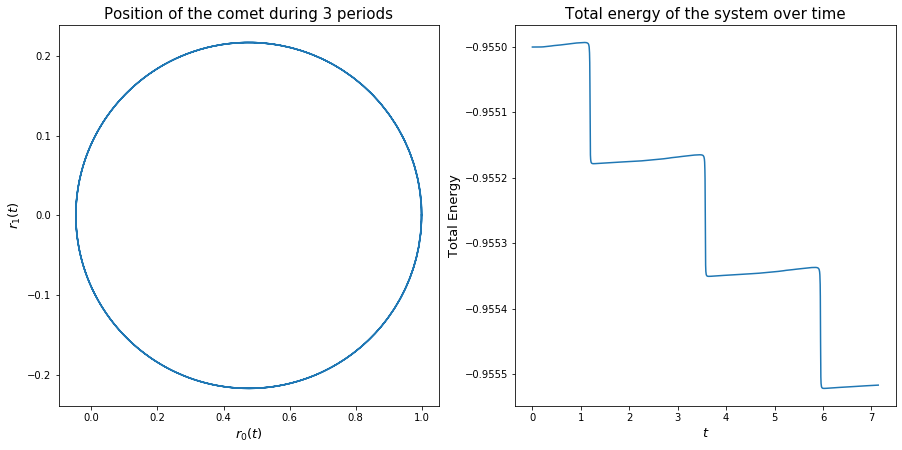

In [7]:
period = 2*pi / (2-0.3**2)**1.5
for tol in [0.01, 0.001, 0.0001]:
    time_obj = simTime(time=0, tol=tol, endTime=3*period, dtmin=1e-6, dtmax=.5)
    result, time_obj = advance(time_obj, array([1, 0, 0, .3]), w)
    y = array([x for x in result[:,4]])
    print(time_obj)
    plt.figure(figsize=(15,7))
    plt.subplot(1,2,1)
    plt.plot(y[:,0], y[:,1])
    plt.title('Position of the comet during 3 periods', size=15)
    plt.xlabel(r'$r_0(t)$', size=13)
    plt.ylabel(r'$r_1(t)$', size=13)

    E = 0.5*norm(y[:,2:], axis=1)**2 - 1/norm(y[:,:2], axis=1)
    plt.subplot(1,2,2)
    plt.plot(result[:,0], E)
    plt.title('Total energy of the system over time', size=15)
    plt.xlabel(r'$t$', size=13)
    plt.ylabel(r'Total Energy', size=13)
    plt.show()

Almost no energy is lost during the 3 periods for the tolerance of $10^{-4}$.